In [1]:
!pip install pytorch-lightning
!pip install transformers
!pip install watermark
!pip install datasets
!pip install transformers[torch]
!pip install accelerate
!pip install huggingface_hub
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirem

In [2]:
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset, Dataset
import numpy as np
import torch
from transformers import ElectraConfig, ElectraModel, ElectraTokenizer, ElectraForSequenceClassification,AdamW,get_linear_schedule_with_warmup
from torch.nn.functional import cross_entropy

config = ElectraConfig(
    vocab_size=30000,
    hidden_size=256,
    num_hidden_layers=12,
    num_attention_heads=4,
    intermediate_size=1024,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    max_position_embeddings=512,
    type_vocab_size=2,
    initializer_range=0.02
)

model = ElectraModel(config)
config = model.config
config.save_pretrained('dnyau/electra_classifier')

In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU disponible.")
else:
    device = torch.device("cpu")
    print("No se encontró GPU. Se utilizará la CPU.")

GPU disponible.


In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [9]:
dataset = load_dataset("solomonk/reddit_mental_health_posts")

def not_none(example):
    return example['body'] is not None

def filter_text(example):
  len_body = len(example['body'])
  if len_body>=500:
    return True
  return False

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

dataset = load_dataset("solomonk/reddit_mental_health_posts")

def prepare_dataframe(df):
  # Concatenate title and body
  df['body'] = df.body.fillna('')
  df['body'] = df.body.str.cat(df.title, sep=' ')

  # Removed deleted posts
  df = df[~df.author.str.contains('\[deleted\]')]
  df = df[~df.body.str.contains('\[removed\]')]
  df = df[~df.body.str.contains('\[deleted\]')]
  df = df[~df.body.str.contains('\[deleted by user\]')]

  # Removed moderador posts
  df = df[df.author!='AutoModerator']

  return df[['body', 'subreddit']]

def not_none(example):
    return example['body'] is not None

dataset = dataset.filter(not_none)

df = dataset["train"].to_pandas()
df = prepare_dataframe(df).reset_index(drop=True)
dataset = Dataset.from_pandas(df)

dataset_sampled = dataset.train_test_split(test_size=0.7, seed=42)['train']

train_val_test = dataset_sampled.train_test_split(test_size=0.2, seed=42)
train_dataset = train_val_test['train']
test_val_dataset = train_val_test['test']

test_val_split = test_val_dataset.train_test_split(test_size=0.5, seed=42)
validation_dataset = test_val_split['train']
test_dataset = test_val_split['test']

columns_to_keep = ['body', 'subreddit']
columns_to_remove = [col for col in dataset_sampled.column_names if col not in columns_to_keep]

train_dataset = train_dataset.remove_columns(columns_to_remove)
validation_dataset = validation_dataset.remove_columns(columns_to_remove)
test_dataset = test_dataset.remove_columns(columns_to_remove)

tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')

le = LabelEncoder()

le.fit(dataset_sampled['subreddit'])

#def encode_labels(example):
#    example['subreddit'] = le.transform([example['subreddit']])[0]
#    return example

def prepare_data(example):
    #print(example['body'])
    encoding = tokenizer.encode_plus(
        example['body'],
        truncation=True,
        max_length=512,
        padding='max_length',
        return_tensors='pt',
    )
    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': torch.tensor(le.transform([example['subreddit']])[0], dtype=torch.long)
    }

# Preprocesar los conjuntos de datos antes de pasarlos al Trainer
train_dataset = train_dataset.map(prepare_data)
validation_dataset = validation_dataset.map(prepare_data)
test_dataset = test_dataset.map(prepare_data)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/19978 [00:00<?, ? examples/s]

Map:   0%|          | 0/2497 [00:00<?, ? examples/s]

Map:   0%|          | 0/2498 [00:00<?, ? examples/s]

In [ ]:
#def compute_metrics(eval_pred):
 #   predictions, labels = eval_pred
 #  predictions = np.argmax(predictions, axis=1)
  #  return accuracy.compute(predictions=predictions, references=labels)

model = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels=len(le.classes_))
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="electra_classifier",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    remove_unused_columns=True,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.evaluate(test_dataset)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Cloning https://huggingface.co/dnyau/electra_classifier into local empty directory.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


In [ ]:
#LOSS FUNCTION

from torch.nn.functional import cross_entropy
# Get the predictions, ground truth values, and loss for each data point in the test dataset
prediction_output = trainer.predict(test_dataset)
predictions = np.argmax(prediction_output.predictions, axis=-1)
labels = prediction_output.label_ids

# Get the loss
torch_tensor = torch.from_numpy(prediction_output.predictions)
labels_torch = torch.tensor(labels)
loss = cross_entropy(torch_tensor,labels_torch, reduction="none")

# Create a dataframe
import pandas as pd

df = pd.DataFrame({'predictions': predictions, 'ground_truth': labels, "losses":loss })

df.predictions = le.inverse_transform(df.predictions)
df.ground_truth = le.inverse_transform(df.ground_truth)
df["text"] = test_dataset["body"]
df["len"] = df.text.str.len()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
import seaborn as sns

def generate_classification_report(predictions, labels, classes):
    report = classification_report(labels, predictions, target_names=classes)
    print("Classification Report:")
    print(report)

def plot_confusion_matrix(predictions, labels, classes):
    confusion = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
generate_classification_report(predictions, labels, le.classes_)

Classification Report:
              precision    recall  f1-score   support

        ADHD       0.93      0.91      0.92       629
         OCD       0.94      0.93      0.93       708
   aspergers       0.80      0.90      0.85       369
  depression       0.82      0.84      0.83       397
        ptsd       0.92      0.86      0.89       395

    accuracy                           0.89      2498
   macro avg       0.88      0.89      0.88      2498
weighted avg       0.90      0.89      0.89      2498



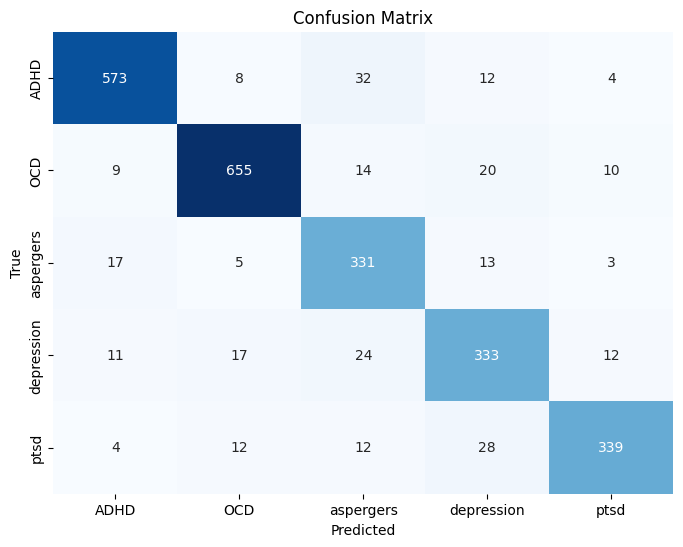

In [ ]:
plot_confusion_matrix(predictions, labels, le.classes_)

In [ ]:
df.sort_values("losses").head(50)

,predictions,ground_truth,losses,text,len
297,OCD,OCD,0.003673,I asked my therapist about OCD and tics. She s...,383
2277,OCD,OCD,0.003675,"Hey guys, I was diagnosed with OCD & GAD years...",453
467,OCD,OCD,0.003688,"hi, i have pure o and it's at the point i want...",514
1145,OCD,OCD,0.003706,Just a little reminder. Otherwise you might th...,380
1281,OCD,OCD,0.003706,Ive been diagnosed with OCD and some depressiv...,1151
1013,OCD,OCD,0.003710,Hey y'all! This is a bit odd and i dont know i...,1084
1425,OCD,OCD,0.003712,I am realizing my OCD will attach onto anythin...,673
1948,OCD,OCD,0.003721,My wife & I got into a semi-heated argument at...,954
2213,OCD,OCD,0.003723,Can OCD cause you to have intrusive thoughts a...,440
1397,OCD,OCD,0.003725,I have been working on my OCD for years. I’ve ...,849


In [ ]:
df.sort_values("losses").tail(50)

,predictions,ground_truth,losses,text,len
397,OCD,ADHD,4.030653,I hate the feeling I feel when I lie to get ou...,588
1543,ptsd,OCD,4.039309,Burping triggers me. It freaks me out and I ha...,395
784,OCD,aspergers,4.075475,I think I have a tendency to make other people...,691
1210,depression,aspergers,4.117448,Also does it still happen if you take anti dep...,311
222,depression,OCD,4.269686,It is a parasite that has latched on to my lif...,1277
578,aspergers,ptsd,4.346340,"I am going biking tomorrow, which will fix thi...",216
1233,OCD,ADHD,4.392086,One of the principal sources of my anxiety is ...,618
1810,depression,ptsd,4.465265,If I could kill myself without it fucking my f...,559
1078,depression,ADHD,4.480078,idek if i can post this here but i need to let...,1421
1675,depression,ptsd,4.532734,"23rd bday,today...never had bdays growing up.....",1009


import numpy as np
from google.colab import autoviz
df_8864265564275177161 = autoviz.get_df('df_8864265564275177161')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_8864265564275177161, *['losses'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1094981845483386191 = autoviz.get_df('df_1094981845483386191')

def value_plot(df, y, sort_ascending=False, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  if sort_ascending:
    df = df.sort_values(y).reset_index(drop=True)
  _, ax = plt.subplots(figsize=figsize)
  df[y].plot(kind='line')
  plt.title(y)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_1094981845483386191, *['len'], **{})
chart

import numpy as np
from google.colab import autoviz
df_674320577220048478 = autoviz.get_df('df_674320577220048478')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_674320577220048478, *['losses'], **{})
chart

import numpy as np
from google.colab import autoviz
df_4044894147925431345 = autoviz.get_df('df_4044894147925431345')

def histogram(df, colname, num_bins=20, figsize=(2, 1)):
  from matplotlib import pyplot as plt
  _, ax = plt.subplots(figsize=figsize)
  plt.hist(df[colname], bins=num_bins, histtype='stepfilled')
  plt.ylabel('count')
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_4044894147925431345, *['len'], **{})
chart

import numpy as np
from google.colab import autoviz
df_2882990893214005470 = autoviz.get_df('df_2882990893214005470')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_2882990893214005470, *['predictions'], **{})
chart

import numpy as np
from google.colab import autoviz
df_3352740295055125825 = autoviz.get_df('df_3352740295055125825')

def categorical_histogram(df, colname, figsize=(2, 1.2), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  _, ax = plt.subplots(figsize=figsize)
  bars = df[colname].value_counts()
  plt.barh(bars.index, bars.values, color=sns.palettes.mpl_palette(mpl_palette_name))
  plt.title(colname)
  ax.spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_3352740295055125825, *['ground_truth'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1560906025447388052 = autoviz.get_df('df_1560906025447388052')

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=8, alpha=.6):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
    plt.xlabel(x_colname)
    plt.ylabel(y_colname)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_1560906025447388052, *[[['losses', 'len']]], **{})
chart

import numpy as np
from google.colab import autoviz
df_5894752751860470613 = autoviz.get_df('df_5894752751860470613')

def heatmap(df, x_colname, y_colname, figsize=(2, 2), mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=figsize)
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df_5894752751860470613, *['predictions', 'ground_truth'], **{})
chart

import numpy as np
from google.colab import autoviz
df_1299070306007779175 = autoviz.get_df('df_1299070306007779175')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_1299070306007779175, *['losses', 'predictions'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_4414301284172526675 = autoviz.get_df('df_4414301284172526675')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_4414301284172526675, *['losses', 'ground_truth'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_5712483792420794777 = autoviz.get_df('df_5712483792420794777')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_5712483792420794777, *['len', 'predictions'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_5016044997476437565 = autoviz.get_df('df_5016044997476437565')

def violin_plot(df, value_colname, facet_colname, col_width=.3, col_length=3, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  plt.figure(figsize=(col_length, col_width * len(df[facet_colname].unique())))
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(df_5016044997476437565, *['len', 'ground_truth'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz
df_2647274192730816937 = autoviz.get_df('df_2647274192730816937')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_2647274192730816937, *['losses', 'len', 'predictions'], **{})
chart

import numpy as np
from google.colab import autoviz
df_7357891223887601303 = autoviz.get_df('df_7357891223887601303')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_7357891223887601303, *['losses', 'len', 'ground_truth'], **{})
chart

import numpy as np
from google.colab import autoviz
df_54274111572400224 = autoviz.get_df('df_54274111572400224')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_54274111572400224, *['losses', 'count()', 'predictions'], **{})
chart

import numpy as np
from google.colab import autoviz
df_908967886197829232 = autoviz.get_df('df_908967886197829232')

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figsize=(2.5, 1.3), mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df_908967886197829232, *['losses', 'count()', 'ground_truth'], **{})
chart

<Axes: xlabel='ground_truth', ylabel='losses'>

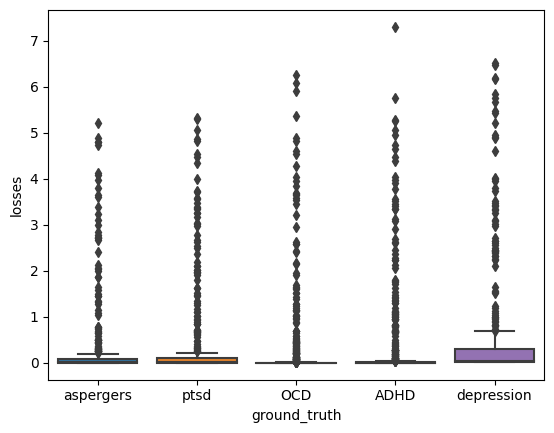

In [ ]:
sns.boxplot(data = df, y = "losses", x = "ground_truth")